In [1]:
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

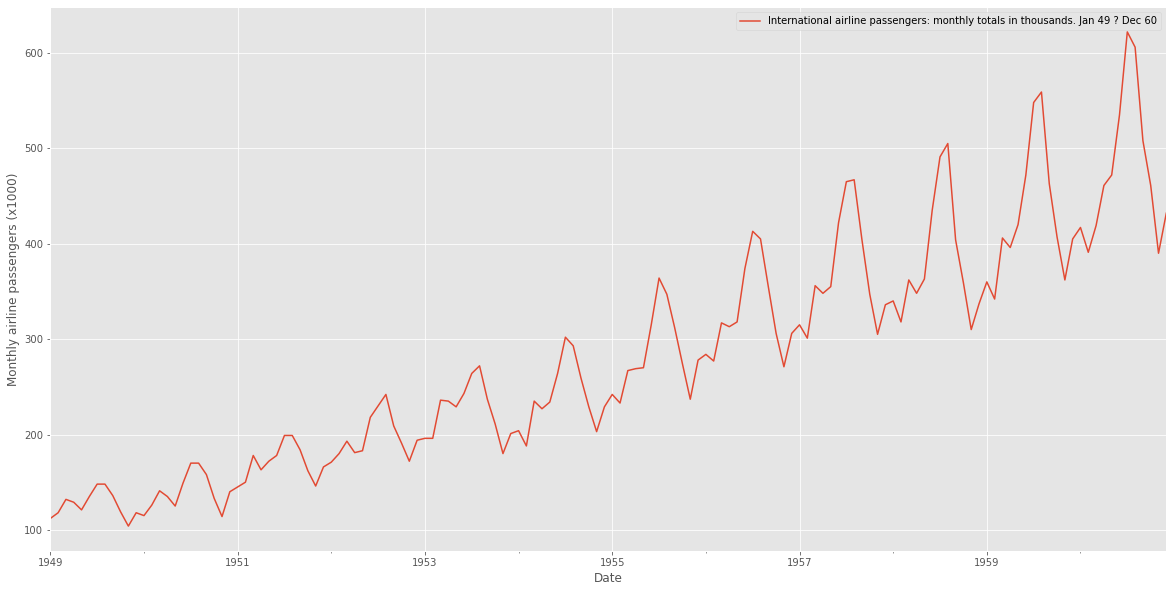

In [2]:
# Load the data
data = pd.read_csv('international-airline-passengers.csv', engine='python', skipfooter=3)
# A bit of pre-processing to make it nicer
data['Month']=pd.to_datetime(data['Month'], format='%Y-%m-%d')
data.set_index(['Month'], inplace=True)

# Plot the data
data.plot()
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.show()

In [3]:
data.head(3)

,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132


In [4]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [6]:
list(itertools.product(p, d, q))

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1),
 (2, 0, 0),
 (2, 0, 1),
 (2, 1, 0),
 (2, 1, 1),
 (3, 0, 0),
 (3, 0, 1),
 (3, 1, 0),
 (3, 1, 1)]

In [7]:
train_data = data['1949-01-01':'1959-12-01']
test_data = data['1960-01-01':'1960-12-01']

In [20]:
test_data.tail(3)

,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
Month,
1960-10-01,461
1960-11-01,390
1960-12-01,432


In [8]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [10]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 618.2055120834116 for model SARIMAX(3, 1, 0)x(3, 1, 1, 12)


In [11]:
# Let's fit this model
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

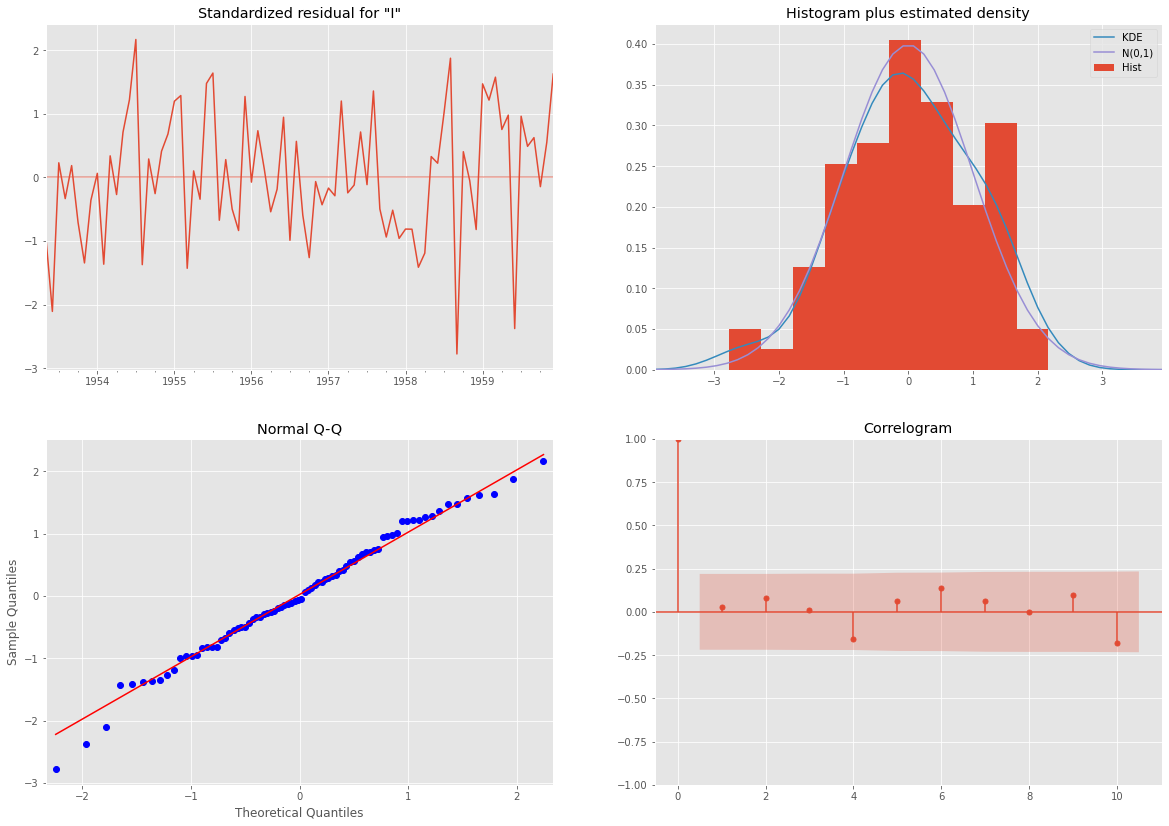

In [12]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()

In [13]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                             SARIMAX Results                                                              
==========================================================================================================================================
Dep. Variable:     International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60   No. Observations:                  132
Model:                                                           SARIMAX(3, 1, 0)x(3, 1, [1], 12)   Log Likelihood                -301.103
Date:                                                                            Sun, 09 May 2021   AIC                            618.206
Time:                                                                                    21:18:36   BIC                            637.262
Sample:                                                                                01-01-1949   HQIC                           625.846
                                                                                     - 12-01-1959                                         
Covariance Type:                                                                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3524      0.115     -3.071      0.002      -0.577      -0.127
ar.L2         -0.0293      0.152     -0.192      0.847      -0.328       0.269
ar.L3          0.0018      0.127      0.014      0.989      -0.247       0.250
ar.S.L12       0.6869      0.236      2.906      0.004       0.224       1.150
ar.S.L24       0.2884      0.140      2.063      0.039       0.014       0.562
ar.S.L36       0.0084      0.018      0.474      0.636      -0.026       0.043
ma.S.L12      -1.0000   2992.194     -0.000      1.000   -5865.592    5863.592
sigma2        86.7628    2.6e+05      0.000      1.000   -5.09e+05    5.09e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 0.79
Prob(Q):                              0.81   Prob(JB):                         0.67
Heteroskedasticity (H):               1.28   Skew:                            -0.23
Prob(H) (two-sided):                  0.52   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.88e+14. Standard errors may be unstable.
"""

In [14]:
pred0 = results.get_prediction(start='1958-01-01', dynamic=False)
pred0_ci = pred0.conf_int()

In [15]:
pred1 = results.get_prediction(start='1958-01-01', dynamic=True)
pred1_ci = pred1.conf_int()

In [16]:
pred2 = results.get_forecast('1962-12-01')
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['1960-01-01':'1960-12-01'])

1960-01-01    419.493359
1960-02-01    397.831375
1960-03-01    460.856822
1960-04-01    449.448843
1960-05-01    474.553048
1960-06-01    537.847636
1960-07-01    614.883590
1960-08-01    628.208366
1960-09-01    519.333927
1960-10-01    462.252140
1960-11-01    412.161040
1960-12-01    452.661173
Freq: MS, Name: predicted_mean, dtype: float64


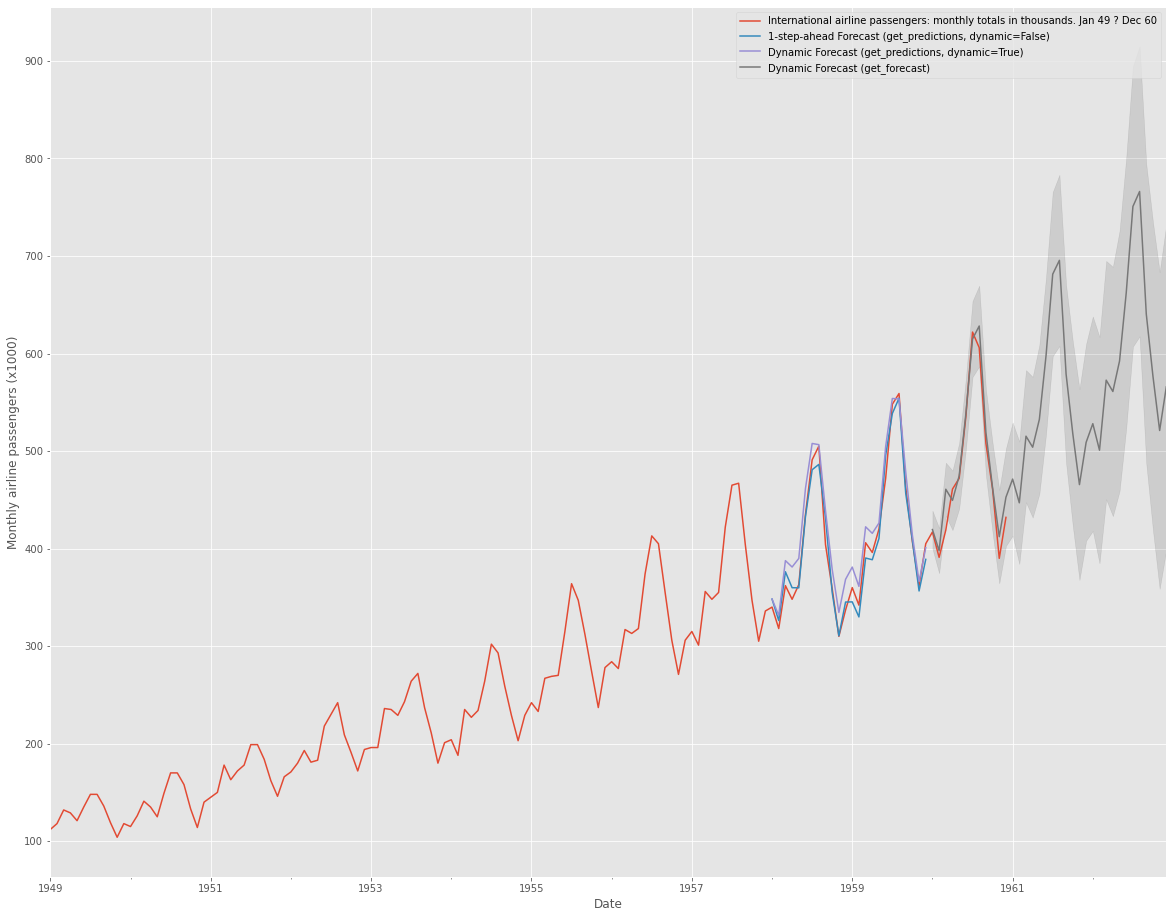

In [18]:
ax = data.plot(figsize=(20, 16))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.legend()
plt.show()

In [19]:
prediction = pred2.predicted_mean['1960-01-01':'1960-12-01'].values
# flatten nested list
truth = list(itertools.chain.from_iterable(test_data.values))
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((truth - prediction) / truth)) * 100

print('The Mean Absolute Percentage Error for the forecast of year 1960 is {:.2f}%'.format(MAPE))

The Mean Absolute Percentage Error for the forecast of year 1960 is 2.81%


In [21]:
results.get_forecast('1963-01-01') #until 1963-01-01

In [29]:
pred3 = results.get_forecast('1963-01-01')
pred3_ci = pred3.conf_int()
print(pred3.predicted_mean['1960-01-01':'1964-01-01'])

1960-01-01    419.493359
1960-02-01    397.831375
1960-03-01    460.856822
1960-04-01    449.448843
1960-05-01    474.553048
1960-06-01    537.847636
1960-07-01    614.883590
1960-08-01    628.208366
1960-09-01    519.333927
1960-10-01    462.252140
1960-11-01    412.161040
1960-12-01    452.661173
1961-01-01    471.259688
1961-02-01    446.930096
1961-03-01    515.244700
1961-04-01    503.917620
1961-05-01    532.451726
1961-06-01    597.777135
1961-07-01    681.401174
1961-08-01    695.557994
1961-09-01    578.964672
1961-10-01    518.067924
1961-11-01    465.574939
1961-12-01    508.938777
1962-01-01    528.062660
1962-02-01    500.878156
1962-03-01    572.711914
1962-04-01    561.067808
1962-05-01    592.351505
1962-06-01    662.161787
1962-07-01    750.776979
1962-08-01    766.150650
1962-09-01    640.584462
1962-10-01    576.663376
1962-11-01    521.085853
1962-12-01    565.829550
1963-01-01    586.427029
Freq: MS, Name: predicted_mean, dtype: float64


In [25]:
pred3_ci

,lower International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60,upper International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
1960-01-01,400.104463,438.882255
1960-02-01,374.741874,420.920876
1960-03-01,433.657463,488.056180
1960-04-01,418.935473,479.962213
1960-05-01,440.983553,508.122542
1960-06-01,501.490755,574.204517
1960-07-01,575.935917,653.831262
1960-08-01,586.832162,669.584570
1960-09-01,475.664000,563.003854
1960-10-01,416.403051,508.101228
